In [1]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib_fontja
os.chdir('../')
from src.feature import *
from src.model import *

c:\Users\1631278\project\manufacturing-dx-purchase-prediction\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


データ準備

In [2]:
# データの読み込み
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
sample_submit = pd.read_csv("data/sample_submit.csv", header=None)

In [3]:
# Xとyの分割
target_col = '購入フラグ'
X_train_df = train.drop(columns=[target_col])
y_train_df = train[target_col]
X_test_df = test.copy()

特徴量エンジニアリング

c:\Users\1631278\project\manufacturing-dx-purchase-prediction\venv\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


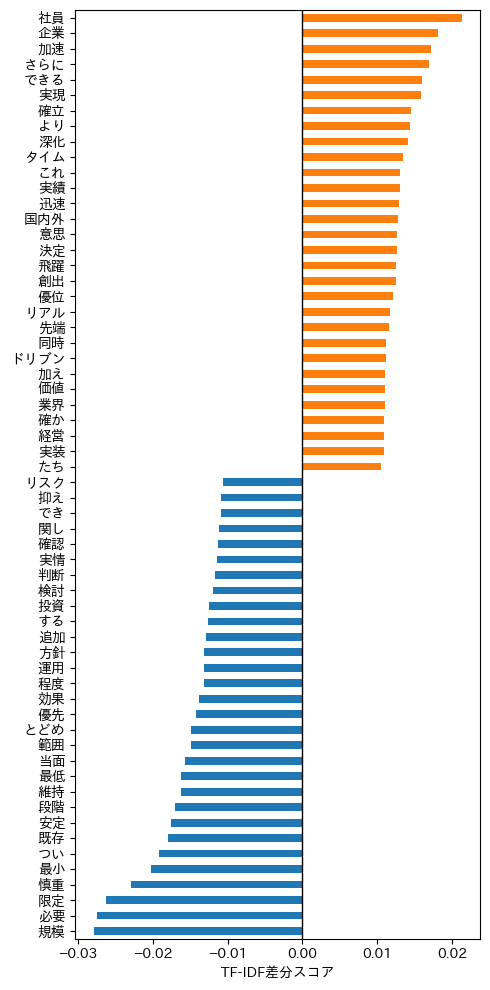

c:\Users\1631278\project\manufacturing-dx-purchase-prediction\venv\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


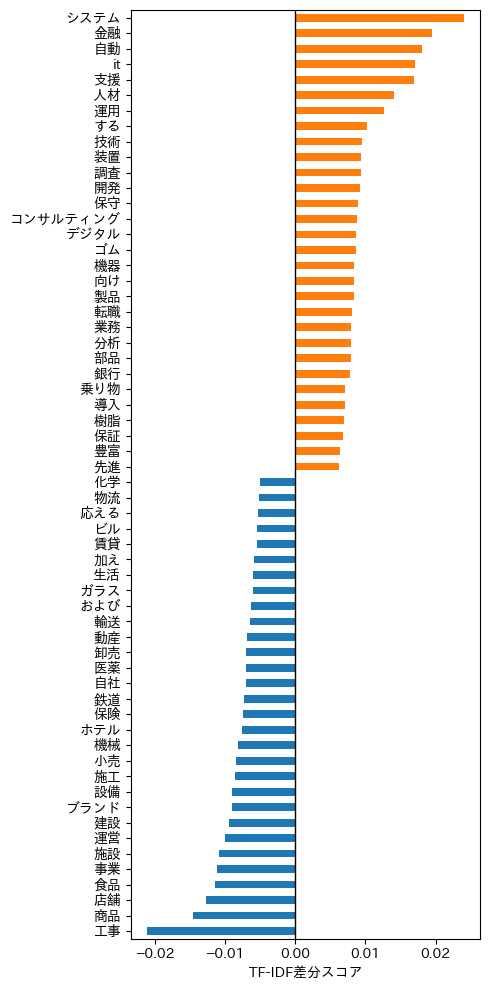

In [4]:
# 学習・テストデータの結合
X_train_df.index = "train_" + X_train_df.index.astype(str)
X_test_df.index = "test_" + X_test_df.index.astype(str)
X_df = pd.concat([X_train_df, X_test_df], axis=0)

# 不要な列の削除
drop_cols = ['企業ID', '企業名']
X_df = X_df.drop(columns=drop_cols)

# 指標の組み合わせによる新規指標の作成
X_df = feature_engineering(X_df)

# カテゴリ変数を数値にエンコード
categorical_cols = ['業界', '上場種別', '特徴']
X_df = onehot_encode_categorical(X_df, categorical_cols)

# ２択（はい/いいえ）変数のエンコード
binary_cols = ['アンケート６']
X_df = encode_binary(X_df, binary_cols, true=1)

# 組織図の特徴量化
org_df = org_chart_features(X_df['組織図'])
X_df = pd.concat([X_df, org_df], axis=1)
X_df = X_df.drop(columns=['組織図'])

# 今後のDX展望テキストデータの特徴量化（文章量, ポジネガ出現率, TF-IDF）
length_df = text_length_features(X_df['今後のDX展望'])
pos_words, neg_words = analyze_tfidf_diff(X_train_df["今後のDX展望"], y_train_df, top_N=30, figsize=(5, 10))
posneg_df = pos_neg_ratio(X_df['今後のDX展望'],
                          positive_words = list(pos_words.index),
                           negative_words = list(neg_words.index),)
X_df = pd.concat([X_df, length_df, posneg_df], axis=1)
X_df = X_df.drop(columns=['今後のDX展望'])

# 企業概要テキストデータの特徴量化（文章量, ポジネガ出現率, TF-IDF）
length_df = text_length_features(X_df['企業概要'])
pos_words, neg_words = analyze_tfidf_diff(X_train_df["企業概要"], y_train_df, top_N=30, figsize=(5, 10))
posneg_df = pos_neg_ratio(X_df['企業概要'],
                          positive_words = list(pos_words.index),
                           negative_words = list(neg_words.index),)
X_df = pd.concat([X_df, length_df, posneg_df], axis=1)
X_df = X_df.drop(columns=['企業概要'])

# 学習・テストデータの再分割
X_train_df = X_df.loc[X_train_df.index].reset_index(drop=True)
X_test_df = X_df.loc[X_test_df.index].reset_index(drop=True)

予測モデルのパラメータ最適化

In [5]:
# 基本パラメータ
lgbm_params_base = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'n_estimators': 1000,
    'is_unbalance': True,
    'random_state': 42,
    'n_jobs': -1,
    'verbose': -1
    }

# 探索するパラメータを定義する「関数」
def define_lgbm_params(trial):
    return {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 80),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
    }

# LightGBMモデルの最適化実行
lgbm_results = optimize_model(
    X_train_df,
    y_train_df,
    model_name="lightgbm",
    params_base=lgbm_params_base,
    define_params_func=define_lgbm_params,
    n_trials=50
)

[I 2025-11-06 19:36:30,809] A new study created in memory with name: no-name-f3665f13-7fda-44bf-8ffa-f2f6a0fcc28f


--- Optimizing lightgbm ---


[I 2025-11-06 19:36:32,629] Trial 0 finished with value: 0.7146373039706373 and parameters: {'learning_rate': 0.014880326653679492, 'num_leaves': 41, 'max_depth': 3, 'min_child_samples': 79, 'subsample': 0.7856081178092481, 'colsample_bytree': 0.729235627387699, 'reg_alpha': 4.010208290146389e-08, 'reg_lambda': 0.7045089527413332}. Best is trial 0 with value: 0.7146373039706373.
[I 2025-11-06 19:36:34,307] Trial 1 finished with value: 0.6978208525816522 and parameters: {'learning_rate': 0.03056986008340724, 'num_leaves': 72, 'max_depth': 6, 'min_child_samples': 7, 'subsample': 0.8292519178038422, 'colsample_bytree': 0.8308209136405692, 'reg_alpha': 4.628913069878267e-07, 'reg_lambda': 5.534647076315007e-07}. Best is trial 0 with value: 0.7146373039706373.
[I 2025-11-06 19:36:35,205] Trial 2 finished with value: 0.6982217906934762 and parameters: {'learning_rate': 0.04304582008162913, 'num_leaves': 75, 'max_depth': 8, 'min_child_samples': 60, 'subsample': 0.8017041661385392, 'colsample_


--- Optimization Finished ---
Best trial for lightgbm:
  Value (Best F1 Score): 0.73345
  Best Params:
    learning_rate: 0.019007936472995743
    num_leaves: 61
    max_depth: 3
    min_child_samples: 35
    subsample: 0.7274800594748314
    colsample_bytree: 0.6019382722187712
    reg_alpha: 1.9342177777088087e-06
    reg_lambda: 2.561958787201713

--- Confusion Matrix (Best Trial at Threshold: 0.3900) ---
--------------------------|Predicted Label              |
--------------------------|-----------------------------|
--------------------------| Negative (0) | Positive (1) |
-----------|--------------|--------------|--------------|
True Label | Negative (0) | 498          | 65           | (TN, FP)
           |--------------|--------------|--------------|
           | Positive (1) | 38           | 141          | (FN, TP)
-----------|--------------|--------------|--------------|

--- Feature Importance (Best Model) ---
               Feature  Importance
0    今後のDX展望_pos_ratio       

In [6]:
# 基本パラメータ
xgb_params_base = {
    'objective': 'binary:logistic', 
    'eval_metric': 'logloss',       
    'n_estimators': 1000,
    'scale_pos_weight': (y_train_df == 0).sum() / (y_train_df == 1).sum(), # 'is_unbalance' の代わり
    'random_state': 42,
    'n_jobs': -1,
    'verbosity': 0,                 # 'verbose': -1 -> 'verbosity': 0
    'booster': 'gbtree'             # デフォルトだが明記
    }

# 探索するパラメータを定義する「関数」
def define_xgb_params(trial):
    return {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
    }

# XGBoostモデルの最適化実行
xgb_results = optimize_model(
    X_train_df,
    y_train_df,
    model_name="xgboost",
    params_base=xgb_params_base,
    define_params_func=define_xgb_params,
    n_trials=50
)

[I 2025-11-06 19:38:07,185] A new study created in memory with name: no-name-39ae2677-a326-43de-b64c-4012c4827933


--- Optimizing xgboost ---


[I 2025-11-06 19:38:19,173] Trial 0 finished with value: 0.6566744487609986 and parameters: {'learning_rate': 0.01804775640597444, 'max_depth': 8, 'min_child_weight': 48, 'subsample': 0.7920699580741628, 'colsample_bytree': 0.8751322939363602, 'reg_alpha': 0.004712860903969931, 'reg_lambda': 3.527613579672088e-06}. Best is trial 0 with value: 0.6566744487609986.
[I 2025-11-06 19:38:22,582] Trial 1 finished with value: 0.6081826271710898 and parameters: {'learning_rate': 0.0644117799396293, 'max_depth': 4, 'min_child_weight': 95, 'subsample': 0.9351851151809287, 'colsample_bytree': 0.7493287473742525, 'reg_alpha': 0.005117003199594662, 'reg_lambda': 3.808573016212936e-08}. Best is trial 0 with value: 0.6566744487609986.
[I 2025-11-06 19:38:32,925] Trial 2 finished with value: 0.6206551095304639 and parameters: {'learning_rate': 0.012904205888903762, 'max_depth': 3, 'min_child_weight': 84, 'subsample': 0.8343647062742546, 'colsample_bytree': 0.6373716174792078, 'reg_alpha': 0.56203801615


--- Optimization Finished ---
Best trial for xgboost:
  Value (Best F1 Score): 0.73967
  Best Params:
    learning_rate: 0.0753315453606038
    max_depth: 3
    min_child_weight: 5
    subsample: 0.7788872247805445
    colsample_bytree: 0.6703088651052185
    reg_alpha: 0.006566048839959926
    reg_lambda: 0.025624271125362277

--- Confusion Matrix (Best Trial at Threshold: 0.2700) ---
--------------------------|Predicted Label              |
--------------------------|-----------------------------|
--------------------------| Negative (0) | Positive (1) |
-----------|--------------|--------------|--------------|
True Label | Negative (0) | 479          | 84           | (TN, FP)
           |--------------|--------------|--------------|
           | Positive (1) | 25           | 154          | (FN, TP)
-----------|--------------|--------------|--------------|

--- Feature Importance (Best Model) ---
              Feature  Importance
0   今後のDX展望_pos_ratio    0.050368
1                 店

In [7]:
# 基本パラメータ
cat_params_base = {
    'objective': 'Logloss', # CatBoostでは'Logloss'を指定
        'iterations': 1000,
        'scale_pos_weight': (y_train_df == 0).sum() / (y_train_df == 1).sum(), # 不均衡データへの対処
        'random_seed': 42,
        'verbose': 0, # 学習ログを非表示
        'early_stopping_rounds': 50 # 早期停止
    }

# 探索するパラメータを定義する「関数」
def define_cat_params(trial):
    return {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'depth': trial.suggest_int('depth', 3, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True), # L2正則化
    }

# CatBoostモデルの最適化実行
cat_results = optimize_model(
    X_train_df,
    y_train_df,
    model_name="catboost",
    params_base=cat_params_base,
    define_params_func=define_cat_params,
    n_trials=50
)

[I 2025-11-06 19:43:43,791] A new study created in memory with name: no-name-9402ca9a-4358-49b3-8d39-7677f60a55fe


--- Optimizing catboost ---


[I 2025-11-06 19:43:51,574] Trial 0 finished with value: 0.5695873785577975 and parameters: {'learning_rate': 0.08035521719468987, 'depth': 9, 'min_data_in_leaf': 81, 'subsample': 0.9853059237821449, 'l2_leaf_reg': 6.529463065790382e-07}. Best is trial 0 with value: 0.5695873785577975.
[I 2025-11-06 19:43:58,157] Trial 1 finished with value: 0.7019667129738677 and parameters: {'learning_rate': 0.029583829278188978, 'depth': 8, 'min_data_in_leaf': 53, 'subsample': 0.7342401504865729, 'l2_leaf_reg': 0.007006563558245116}. Best is trial 1 with value: 0.7019667129738677.
[I 2025-11-06 19:44:03,903] Trial 2 finished with value: 0.6812464963181648 and parameters: {'learning_rate': 0.058042490876268366, 'depth': 8, 'min_data_in_leaf': 95, 'subsample': 0.6555161814985561, 'l2_leaf_reg': 0.059677792272578335}. Best is trial 1 with value: 0.7019667129738677.
[I 2025-11-06 19:45:10,589] Trial 3 finished with value: 0.6968047807967862 and parameters: {'learning_rate': 0.027270046412117735, 'depth'


--- Optimization Finished ---
Best trial for catboost:
  Value (Best F1 Score): 0.75458
  Best Params:
    learning_rate: 0.03046505789297418
    depth: 5
    min_data_in_leaf: 82
    subsample: 0.8699992989614899
    l2_leaf_reg: 3.712900269315825

--- Confusion Matrix (Best Trial at Threshold: 0.4800) ---
--------------------------|Predicted Label              |
--------------------------|-----------------------------|
--------------------------| Negative (0) | Positive (1) |
-----------|--------------|--------------|--------------|
True Label | Negative (0) | 511          | 52           | (TN, FP)
           |--------------|--------------|--------------|
           | Positive (1) | 39           | 140          | (FN, TP)
-----------|--------------|--------------|--------------|

--- Feature Importance (Best Model) ---
               Feature  Importance
0    今後のDX展望_pos_ratio   10.931660
1    今後のDX展望_neg_ratio    9.622384
2       企業概要_neg_ratio    6.300109
3       企業概要_pos_ratio    5

In [8]:
# アンサンブルモデルの学習
ensemble_result = train_ensemble_models(
    X_train_df=X_train_df,
    y_train_df=y_train_df,
    X_test_df=X_test_df,
    lgb_best_params = lgbm_results['best_params'],
    xgb_best_params = xgb_results['best_params'],
    cat_best_params = cat_results['best_params'],
    sample_submit=sample_submit,
    n_folds=5,
    early_stopping_rounds=50,
    thresholds=np.arange(0.1, 0.5, 0.01),
    random_state=42
)

--- Start Ensemble Training ---
Fold 1/5 started...
Fold 2/5 started...
Fold 3/5 started...
Fold 4/5 started...
Fold 5/5 started...
--- Ensemble Training Finished ---

--- Evaluation ---
Ensemble Best F1: 0.75248 (Threshold: 0.35)
LightGBM: 0.73247 (Threshold: 0.39)
XGBoost:  0.73861 (Threshold: 0.27)
CatBoost: 0.75472 (Threshold: 0.48)
